### Algorithm 2 -> filtering real time. Creating a moving buffer and simple thresholding

The detection of spikes with filtering and a variant of thresholding works well, but it is not a good idea to do it in a real time system since the overall mean, median and std deviation will not be available.

Hence, for the second algorithm I aim to use of the concepts I learned recently related to adaptive filtering which is quite commonplace for processing of real time systems.

For algorithm 2, I will keep a small buffer that will store the data. I will then follow algorithm 1 on this small sample of data and output 1 when a spike is detected

In [47]:
## imports for the required modules

import sys
import math
import numpy as np

## for signal processing applications
from scipy.signal import butter, sosfiltfilt, filtfilt, sosfreqz
from scipy.fft import fft, fftfreq
from scipy import signal

## For plotting signals
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## running buffer to store the samples
buffer = np.zeros(400, dtype=np.int64)

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b = butter(order, [low, high], btype='band', output='sos')
    return b

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b= butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(b, data)
    return y

In [119]:
csv_file = "./data/example_data.csv"
row_to_plot = 2 ## 1->5

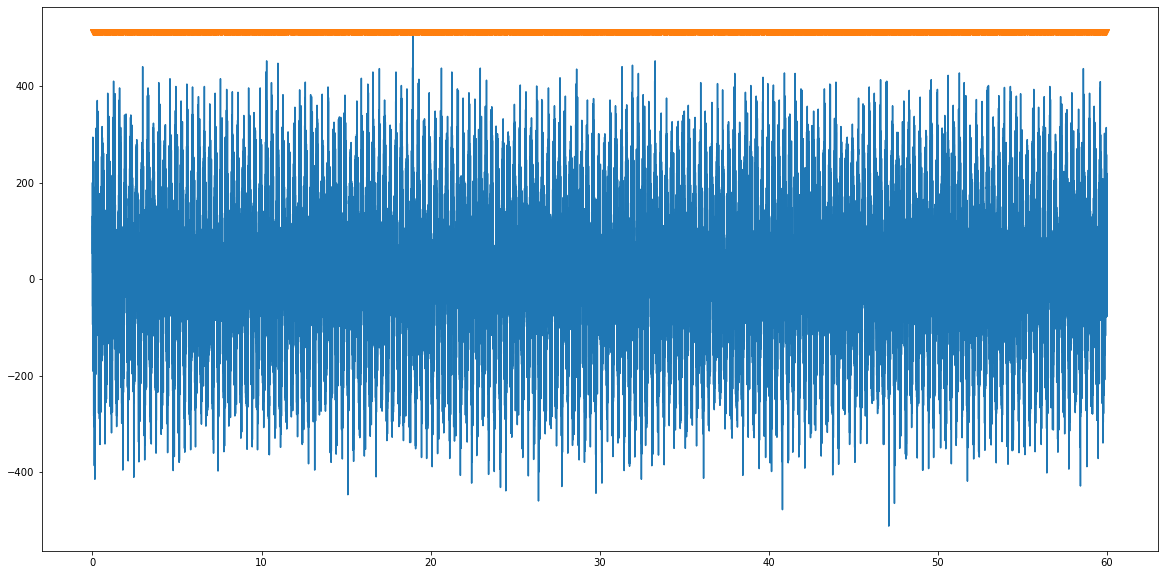

In [120]:
## taken from the script visualize_signal.py

plt.rcParams["figure.figsize"] = [20, 10]

with open(csv_file, 'r') as f:
    original_data = f.read().split('\n')[1:]
    original_data = original_data[row_to_plot].split(',')
    spike_positions = [int(x) for x in original_data[1].split(';')]
    samples = [int(x) for x in original_data[0].split(';')]

spikes = [math.nan] * len(samples)

# Plot spike indicators above all samples.
spike_y = max(samples) + 1

# Replace the values in the positions of the spikes with the maximum sample value
for s in spike_positions:
    spikes[s] = spike_y

# Generate the time vector (fs=20kHz)
t = [x/20000 for x in range(len(samples))]

plt.plot(t, samples)
plt.plot(t, spikes, 'v')
plt.show()

#### Algorithm 2 begins here. I will simulate the incoming signal samples as a loop and try to get the predicted spikes in an array. The formula for threshold of the spikes stays the same as algorithm 1

In [121]:
## spiked contains 1 at points where spikes occured. Initialized as a zero array. Creating it as a boolean to 
## save space

spiked = np.zeros(400, dtype=bool)

In [122]:
## create the bandpass filter coefficients in advance
lowcut = 450
highcut = 6500
fs = 20000
order = 8
b = butter_bandpass(lowcut, highcut, fs, order=order)

In [127]:
b

array([[ 0.0308456 ,  0.06169121,  0.0308456 ,  1.        ,  0.39832378,
         0.0506445 ],
       [ 1.        ,  2.        ,  1.        ,  1.        ,  0.46689062,
         0.15209394],
       [ 1.        ,  2.        ,  1.        ,  1.        ,  0.59170771,
         0.36147679],
       [ 1.        ,  2.        ,  1.        ,  1.        ,  0.77891122,
         0.72416335],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.7176049 ,
         0.73837545],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.7651064 ,
         0.78516557],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.84073602,
         0.86020774],
       [ 1.        , -2.        ,  1.        ,  1.        , -1.931009  ,
         0.9505775 ]])

In [123]:
mean = 0
std_dev = 0
N = 3.5
buffer = samples[:400]
window = signal.windows.hann(400)
spikes_i_got = np.zeros(len(samples), dtype=bool)
total_spikes = 0

for i in range(len(samples[401:])):
    spiked = np.zeros(400, dtype=bool)
    spiked_mean = np.zeros(400, dtype=bool)
    buffer[:-1] = buffer[1:]
    buffer[-1] = samples[i+400]
    filtered = sosfiltfilt(b, buffer)
    mean = np.mean(filtered)
    sigma =np.median(np.abs(filtered-mean)/0.6745)
#     plt.plot(filtered)
#     plt.plot(spikes[i:i+400], "v")
#     plt.plot(buffer)
    spiked[filtered>N*sigma] = True
#     plt.plot(500*spiked)
#     plt.show()
    if spiked[200]==True and spiked[201]==False:
        total_spikes+=1

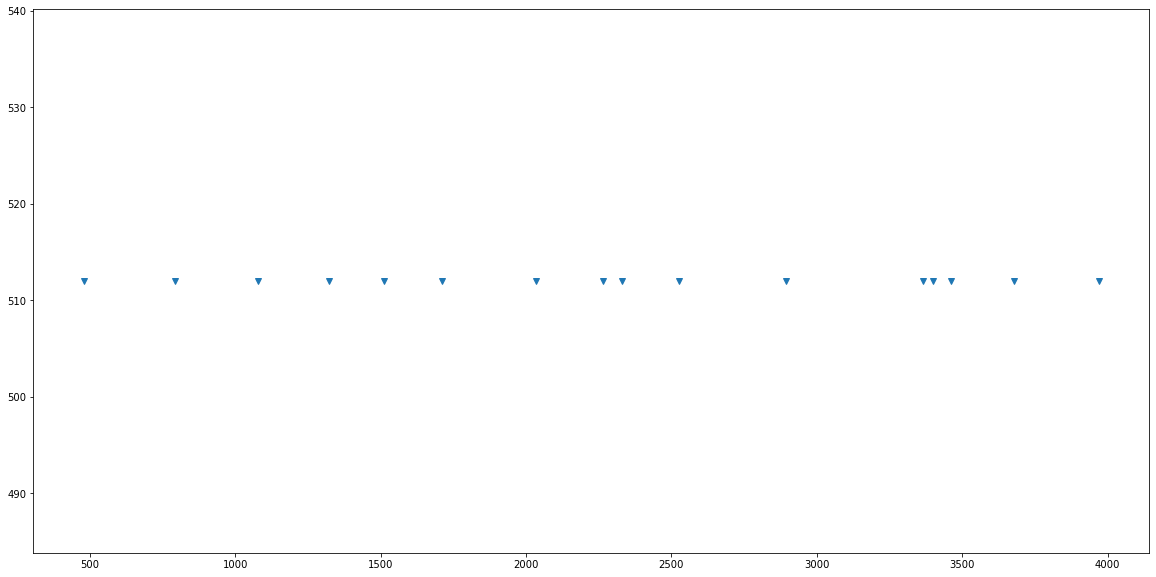

In [124]:
plt.plot(spikes[:4000], "v")

In [125]:
total_spikes

3393

In [126]:
np.count_nonzero(~np.isnan(spikes))

3471

#### Next step is to take a closer look into the spikes getting generated and if I am missing some.